<a href="https://colab.research.google.com/github/difasapi/project/blob/main/Vegetable_15-acc0.91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Common
import os 
import keras
import numpy as np 
import tensorflow as tf
import random

# Data 
from keras.preprocessing.image import ImageDataGenerator

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image

# Callbacaks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers

In [2]:
!pip install -q kaggle
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"difafarhanihakim","key":"3d44a4b5b0da283fd36cc50bd761b3eb"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                             title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                             9KB  2022-10-06 08:55:25          14550        434  1.0              
swaptr/layoffs-2022                                             Layoffs 2022                                29KB  2022-11-16 20:46:46            915         34  1.0              
akshaydattatraykhare/data-for-admission-in-the-university       Data for Admission in the University         4KB  2022-10-27 11:05:45           3344         74  1.0              
aneesayoub/world-universities-ranking-2022                      World Universities Ranking 2022          

# Download Datasets

In [5]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

 99% 529M/534M [00:03<00:00, 200MB/s]
100% 534M/534M [00:03<00:00, 145MB/s]


In [6]:
!unzip /content/vegetable-image-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Vegetable Images/train/Radish/0001.jpg  
  inflating: /content/Vegetable Images/train/Radish/0002.jpg  
  inflating: /content/Vegetable Images/train/Radish/0003.jpg  
  inflating: /content/Vegetable Images/train/Radish/0004.jpg  
  inflating: /content/Vegetable Images/train/Radish/0005.jpg  
  inflating: /content/Vegetable Images/train/Radish/0006.jpg  
  inflating: /content/Vegetable Images/train/Radish/0007.jpg  
  inflating: /content/Vegetable Images/train/Radish/0008.jpg  
  inflating: /content/Vegetable Images/train/Radish/0009.jpg  
  inflating: /content/Vegetable Images/train/Radish/0010.jpg  
  inflating: /content/Vegetable Images/train/Radish/0011.jpg  
  inflating: /content/Vegetable Images/train/Radish/0012.jpg  
  inflating: /content/Vegetable Images/train/Radish/0013.jpg  
  inflating: /content/Vegetable Images/train/Radish/0014.jpg  
  inflating: /content/Vegetable Images/train/Radish/0015.jpg  
  in

# Detect class name

In [7]:
root_path = '/content/Vegetable Images/train/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 15 
Class Names : ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']


In [8]:
# Visualize 
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

# Data Load

In [31]:
input_shape = (256,256,3)
input_shape2 = (256,256)
BATCH = 32

In [32]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 370 using train_datagen generator
train_gen = train_datagen.flow_from_directory(
        root_path,  # This is the source directory for training images
        class_mode ='binary',
        target_size= input_shape2,  # All images will be resized to 200x200
        shuffle = True,
        batch_size=BATCH)

test_gen = train_datagen.flow_from_directory(
        root_path.replace('train','test'),  # This is the source directory for training images
        class_mode ='binary',
        target_size= input_shape2,  # All images will be resized to 200x200
        shuffle = True,
        batch_size=BATCH)

# Flow validation images in batches of 20 using valid_datagen generator
validation_gen = validation_datagen.flow_from_directory(
        root_path.replace('train','validation'),  # This is the source directory for training images
        class_mode ='binary',
        target_size= input_shape2,  # All images will be resized to 200x200
        shuffle = True,
        batch_size=BATCH)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [33]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_gen):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
        
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

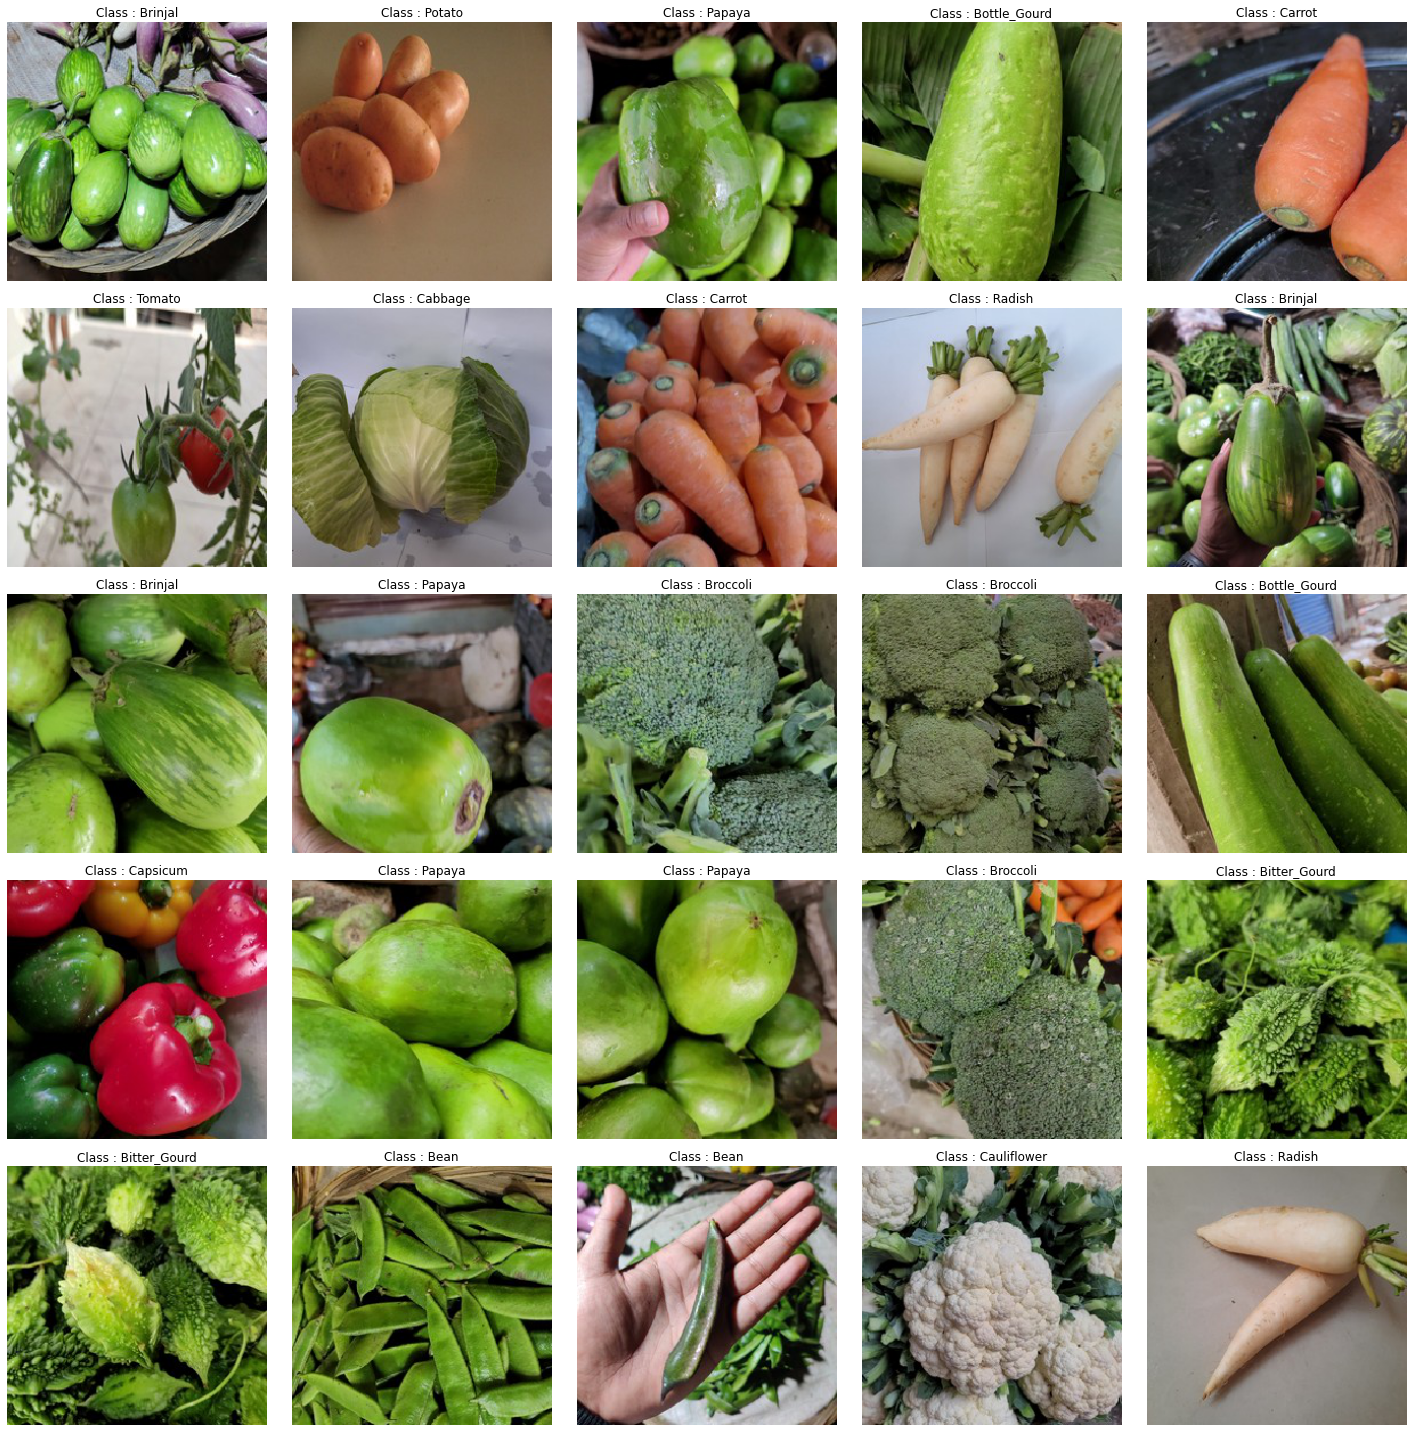

In [34]:
show_images()

# Model Vege Destroyer

In [91]:
model1 = Sequential([])

model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(n_classes, activation='softmax'))
      

In [92]:
model1.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
name ='vegetable_destroyer'

In [94]:
cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint('model.best.h5', save_best_only=True)]

In [95]:
hist_1 = model1.fit(
      train_gen,
      validation_data = validation_gen,
      callbacks = cbs,
      epochs = 20,
      batch_size = BATCH)

Epoch 1/20
469/469 [==============================] - 54s 114ms/step - loss: 2.5055 - accuracy: 0.1338 - val_loss: 2.0865 - val_accuracy: 0.3043
Epoch 2/20
469/469 [==============================] - 52s 110ms/step - loss: 1.9477 - accuracy: 0.3296 - val_loss: 1.4356 - val_accuracy: 0.5487
Epoch 3/20
469/469 [==============================] - 52s 112ms/step - loss: 1.5000 - accuracy: 0.4890 - val_loss: 1.0890 - val_accuracy: 0.6560
Epoch 4/20
469/469 [==============================] - 52s 110ms/step - loss: 1.1281 - accuracy: 0.6307 - val_loss: 0.7968 - val_accuracy: 0.7503
Epoch 5/20
469/469 [==============================] - 52s 111ms/step - loss: 0.8683 - accuracy: 0.7245 - val_loss: 0.7025 - val_accuracy: 0.7800
Epoch 6/20
469/469 [==============================] - 52s 111ms/step - loss: 0.6398 - accuracy: 0.7977 - val_loss: 0.5397 - val_accuracy: 0.8357
Epoch 7/20
469/469 [==============================] - 51s 109ms/step - loss: 0.5598 - accuracy: 0.8341 - val_loss: 0.4972 - val_ac

In [97]:
hist = hist_1.history
v_acc = hist['val_accuracy'][-1]
epoch = len(hist['val_accuracy']) 
print(epoch, round(v_acc,3))
model1.save('/content/model.' + str(epoch) + '-' + str(round(v_acc,3)) + '.h5')

In [98]:
# Architecture
model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 127, 127, 32)      0         
                                                                 
 conv2d_42 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 62, 62, 64)       

In [99]:
model1.evaluate(test_gen)

94/94 [==============================] - 9s 99ms/step - loss: 0.3777 - accuracy: 0.9180


[0.3777199685573578, 0.9179999828338623]

In [69]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set(xlabel='Epoch', ylabel='Accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set(xlabel='Epoch', ylabel='Accuracy')
    ax[1].legend()
    plt.show()

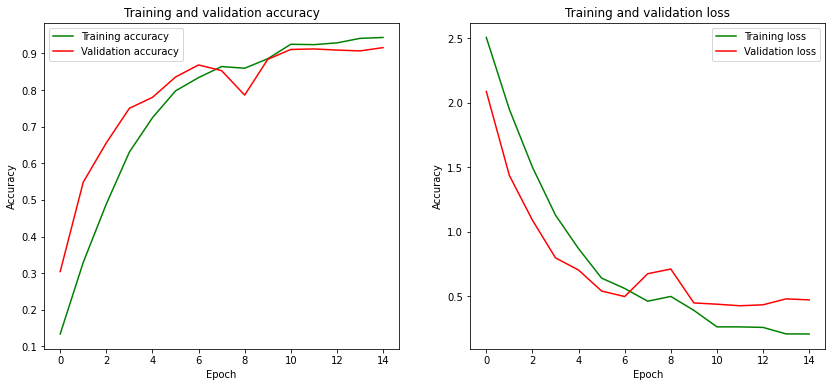

In [100]:
plot_accuracy_and_loss(hist_1)

1/1 [==============================] - 0s 16ms/step


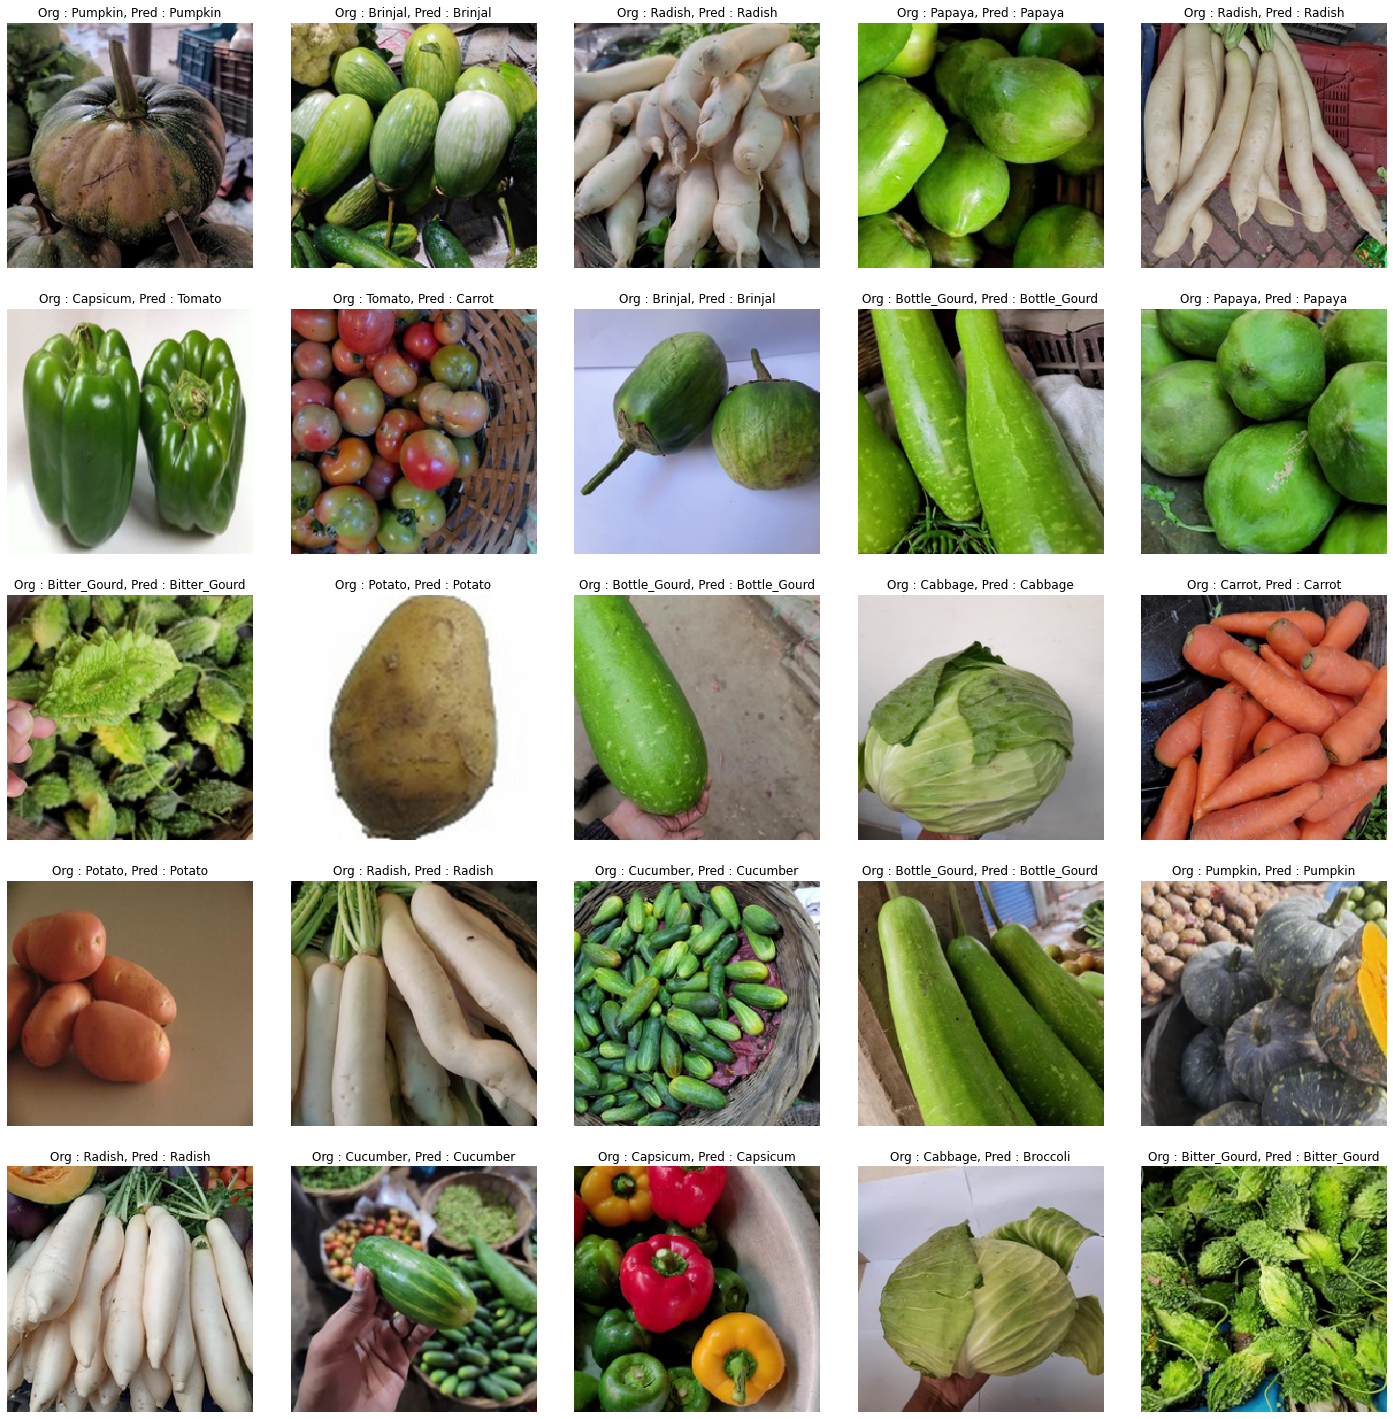

In [101]:
show_images(model=model1, data=test_gen)

In [125]:
import shutil

In [126]:
# file_to = '/content/Vegatable CNN'
# file_format = 'zip'
# file_from = '/content/'
# shutil.make_archive(file_to, file_format, file_from)

'/content.zip'

In [ ]:
files.download('/content/Vegetable CNN destroyer.zip')

# Reference
- Download Kaggle : https://www.kaggle.com/general/74235#1376561
- Vegetable Datasets:
  * https://www.researchgate.net/publication/352846889_DCNN-Based_Vegetable_Image_Classification_Using_Transfer_Learning_A_Comparative_Study
  * https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
- Vegetable acc 99 : https://www.kaggle.com/code/utkarshsaxenadn/vegetable-classification-resnet50v2-acc-99/notebook
- Download G. Colab : 
  * https://pangpuriye.superai.me/google-colab-zip-and-unzip-file/
  * https://predictivehacks.com/?all-tips=how-to-download-files-and-folders-from-colab 
